In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Make sure mmc repository is in pythonpath
import sys
sys.path.append('/home/dallaert/tools/a2e-mmc/')

In [4]:
from mmctools.plotting import plot_timeheight, plot_timehistory_at_height, plot_profile, plot_spectrum

In [5]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16

# Demonstrate plotting library

## Load data

Load a processed TTU dataset for demonstration purposes. The dataset can be obtained by running the notebook "process_TTU_tower.ipynb" which can be found in the [a2e-mmc/assessment repository](https://github.com/a2e-mmc/assessment) (currently only in the dev branch)

In [6]:
datadir = './'
TTUdata = 'TTU_tilt_corrected_20131108-09.csv'

In [7]:
df = pd.read_csv(os.path.join(datadir,TTUdata),parse_dates=True,index_col='datetime')
df.head()

,height,u,v,w,t,ts,p
datetime,,,,,,,
2013-11-08,0.9,-0.138929,2.637817,0.074016,284.794,289.410000,908.547754
2013-11-08,2.4,-0.601111,2.783204,0.487330,284.932,290.979994,908.723508
2013-11-08,4.0,0.416792,4.043940,0.295800,285.166,287.520000,908.215548
2013-11-08,10.1,-0.276479,5.227110,-0.418065,285.298,287.250000,907.611414
2013-11-08,16.8,0.034364,5.908367,-0.173836,285.414,287.610000,907.307654


Do some additional data processing

In [8]:
# Calculate wind speed and direction
df['wspd'] = np.sqrt(df['u']**2 + df['v']**2)
df['wdir'] = 180. + np.arctan2(df['u'],df['v'])*180./np.pi
df['theta'] = df['t'] * (1000./df['p'])**0.286

In [9]:
# Calculate 10min averages
df10 = df.pivot(columns='height',values=['wspd','wdir','w','theta']).resample('10min').mean().stack()
df10.reset_index(inplace=True)
df10.set_index(['datetime'],inplace=True)

## Default plotting tools

Pivoting Dataset


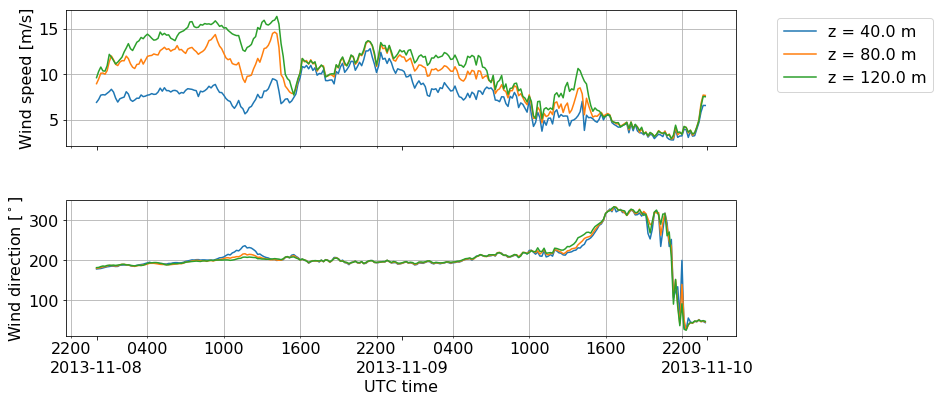

In [10]:
fig,ax = plot_timehistory_at_height(df10,
                                    fields = ['wspd','wdir'],
                                    heights = [40,80,120],
                                   )

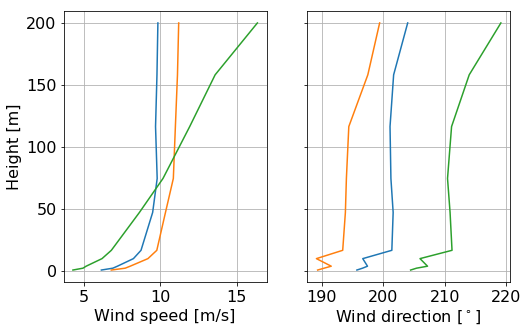

In [11]:
fig,ax = plot_profile(df10,
                      fields = ['wspd','wdir'],
                      times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                     )

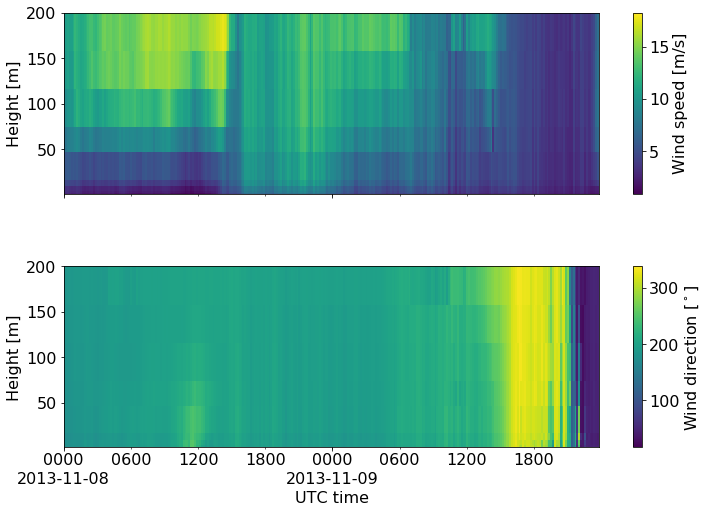

In [12]:
fig,ax,cbar = plot_timeheight(df10,
                              fields = ['wspd','wdir'],
                             )

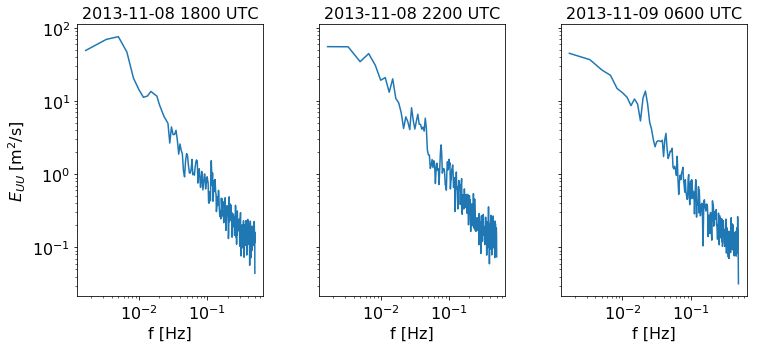

In [13]:
fig,ax = plot_spectrum(df,
                       height = 80,
                       fields = 'wspd',
                       times = ['2013-11-08 18:00:00','2013-11-08 22:00:00','2013-11-09 6:00:00'],
                      )

## Advanced plotting examples

Plot timehistory at all TTU heights using a custom colormap

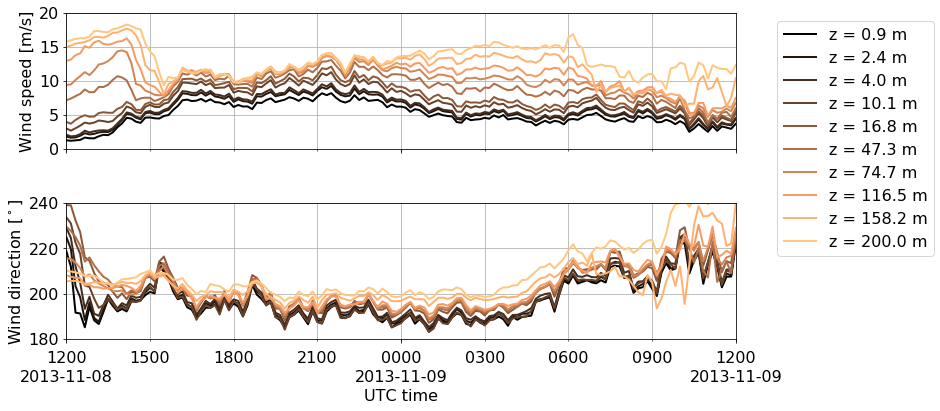

In [14]:
fig,ax = plot_timehistory_at_height(df10,
                                    fields = ['wspd','wdir'],
                                    heights = df10.height.unique(),
                                    # Specify field limits
                                    fieldlimits={'wspd':(0,20),'wdir':(180,240)},
                                    # Specify height limits
                                    timelimits=('2013-11-08 12:00:00','2013-11-09 12:00:00'),
                                    # Specify colormap
                                    colormap='copper',
                                    # Additional keyword arguments to personalize plotting style
                                    linewidth=2,linestyle='-',marker=None,
                                   )

#Move xs tick down slightly to avoid overlap with y ticks in ax[1]
ax[-1].tick_params(axis='x', which='minor', pad=10)
ax[-1].tick_params(axis='x', which='major', pad=10)

# Adjust xaxis tick locations
ax[-1].xaxis.set_minor_locator(mpl.dates.HourLocator(byhour=range(24),interval=3))
ax[-1].xaxis.set_major_locator(mpl.dates.AutoDateLocator(minticks=2,maxticks=3))

Compare instantaneous profiles with 10-min averaged profiles.

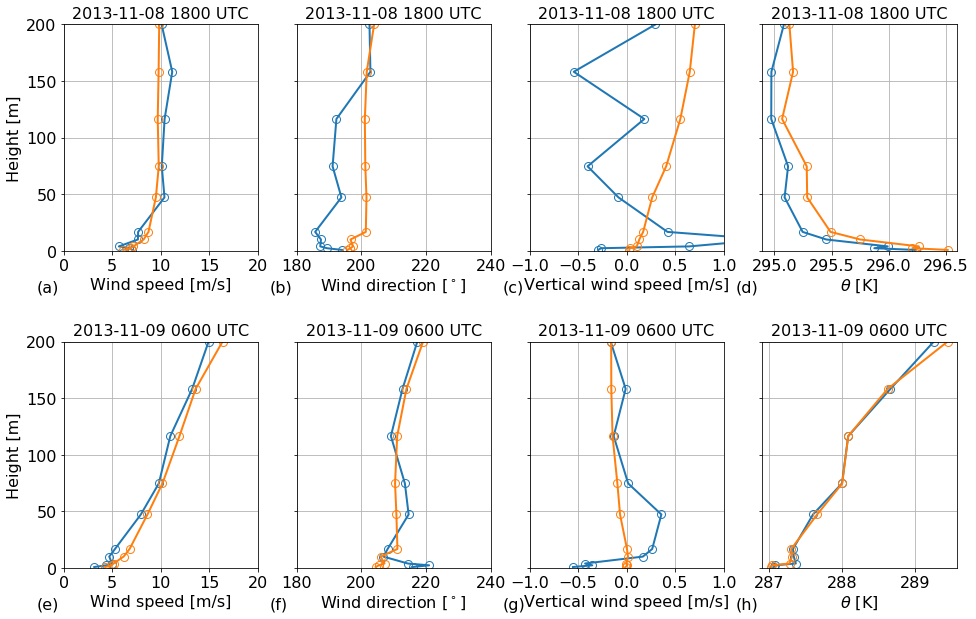

In [15]:
fig,ax = plot_profile(datasets={'Instantaneous data':df,'10-min averaged data':df10},
                      fields=['wspd','wdir','w','theta'],
                      times=['2013-11-08 18:00:00','2013-11-09 06:00:00'],
                      # Specify field limits
                      fieldlimits={'wspd':(0,20),'wdir':(180,240),'w':(-1,1)},
                      # Specify height limits
                      heightlimits=(0,200),
                      # Stack results by dataset instead of times
                      stack_by_datasets=True,
                      # Specify custom field labels
                      fieldlabels={'w':'Vertical wind speed [m/s]','theta':r'$\theta$ [K]'},
                      # Label subplots
                      labelsubplots=True,
                      # Change field order to have different fields correspond to different columns instead of rows
                      fieldorder='F',
                      # Additional keyword arguments to personalize plotting style
                      linewidth=2,marker='o',markersize=8,mfc="none",
                     )